# Explainable RAG with DeepEval

This notebook demonstrates how to build a **Contextual Semantic Search** system using **Chroma Vector Database** and **LiteLLM** with the **Gemini model**. The system processes a folder of PDF documents, builds a knowledge base, and retrieves contextually relevant information to answer user queries. Below is an overview of the tools and methods used.

---

## Tools Used

1. **Chroma Vector Database**:
    - A vector database designed for storing and querying embeddings.
    - Enables efficient similarity search for retrieving semantically relevant documents.

2. **Sentence Transformers**:
    - A library for generating high-quality embeddings (vector representations) of text.
    - Uses pre-trained models like `all-MiniLM-L6-v2` to convert text into embeddings.

3. **LangChain**:
    - A framework for working with text data, including text splitting and chunking.
    - The `RecursiveCharacterTextSplitter` is used to split text into semantically meaningful chunks.

4. **LiteLLM**:
    - A lightweight library for interacting with large language models (LLMs).
    - Used here to call the **Gemini model** for generating responses based on retrieved context.

5. **PyPDF2**:
    - A library for extracting text from PDF files.
    - Used to process all PDFs in a specified folder.

6. **DeepEval**:
    - A library for evaluating LLM outputs.
    - Used to assess the quality of the generated responses based on metrics like contextual precision, recall, relevancy, answer relevancy and faithfulness.

7. **Cross-Encoder**:
    - A model used for re-ranking retrieved documents based on their relevance to the query.
    - Improves the quality of the context provided to the LLM.

---

## Methods and Steps

### Step 1: Extract Text from PDFs
- All PDF files in a specified folder are processed using **PyPDF2**.
- The text from each PDF is extracted and combined into a single string.

### Step 2: Split Text into Chunks
- The combined text is split into smaller chunks using **LangChain's RecursiveCharacterTextSplitter**.
- This ensures that the chunks are semantically meaningful and retain context.

### Step 3: Generate Embeddings
- Each text chunk is converted into an embedding (vector representation) using **Sentence Transformers**.
- The embeddings capture the semantic meaning of the text.

### Step 4: Build the Knowledge Base
- The embeddings and corresponding text chunks are stored in **Chroma Vector Database**.
- This allows for efficient similarity searches based on semantic meaning.

### Step 5: Perform Semantic Search and Reranking
- A user query is converted into an embedding.
- The most semantically similar chunks are retrieved from the Chroma database using the embedding.
- The retrieved documents are then reranked using a Cross-Encoder model to ensure the most relevant context is used.

### Step 6: Generate Responses and Evaluation
- The reranked chunks are passed as context to the **Gemini model** via **LiteLLM**.
- The model generates a response based on the query and the provided context.
- The generated response is then evaluated using **DeepEval** metrics to measure its quality.

---

## Workflow Overview

1. **Input**: A folder containing PDF documents.
2. **Processing**:
    - Extract text from PDFs.
    - Split text into chunks.
    - Generate embeddings and store them in Chroma.
3. **Query Handling**:
    - Convert the query into an embedding.
    - Retrieve the most relevant chunks from Chroma.
    - Rerank the retrieved chunks using Cross-Encoder.
    - Generate a response using the Gemini model.
    - Evaluate the response using DeepEval.
4. **Output**: A contextually accurate and evaluated answer to the user's query.

---

## Why This Approach?

- **Contextual Semantic Search**: Goes beyond keyword matching to understand the meaning and context of the query.
- **Efficient Retrieval**: Chroma enables fast and scalable similarity searches.
- **High-Quality Responses**: The Gemini model generates accurate and contextually relevant answers.
- **Improved Context with Reranking**: The Cross-Encoder reranking step ensures the LLM receives the most pertinent information.
- **Evaluation**: DeepEval provides a way to quantify the quality of the LLM's responses.

---

Let’s get started! You can see the full workflow in the code provided.  A diagram could be added here for a more visual representation of the workflow.

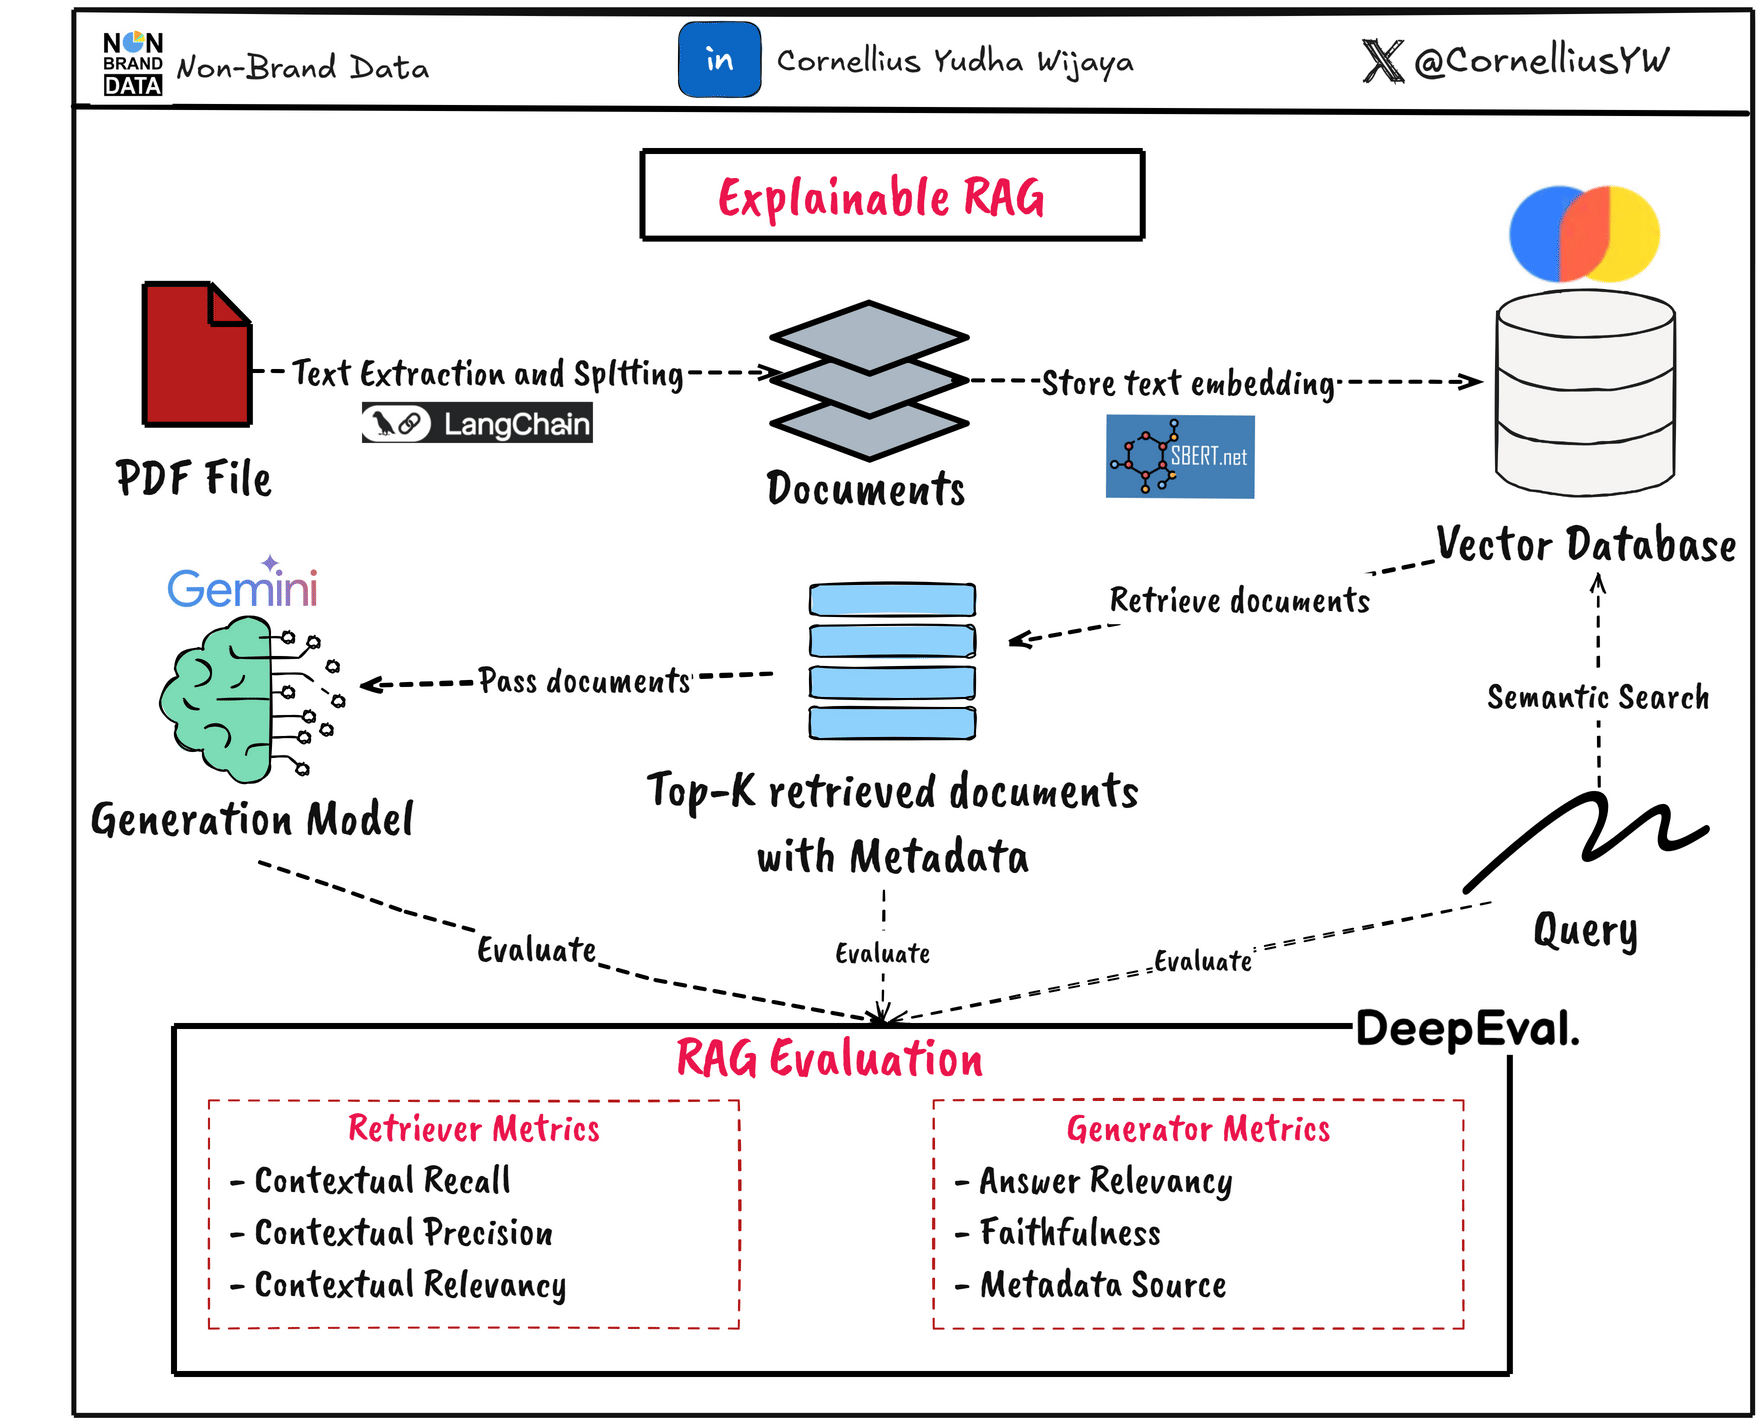

## Library Installation

Start by installing the library used in this Notebook

In [1]:
!pip install -q chromadb pypdf2 sentence-transformers litellm langchain deepeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.1/559.1 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Import the Libraries and set the environment variables

In [40]:
import os
import PyPDF2
from sentence_transformers import SentenceTransformer, CrossEncoder
import chromadb
from chromadb.config import Settings
import litellm
from litellm import completion
from langchain.text_splitter import RecursiveCharacterTextSplitter
import pandas as pd
from deepeval.metrics import (
    ContextualPrecisionMetric,
    ContextualRecallMetric,
    ContextualRelevancyMetric,
    AnswerRelevancyMetric,
    FaithfulnessMetric
)
from deepeval.test_case import LLMTestCase


# # Set environment variables. Uncomment this if you want to set them directly.
# os.environ["HUGGINGFACE_TOKEN"] = "your_huggingface_token_here"
# os.environ["GEMINI_API_KEY"] = "your_gemini_api_key_here"
# os.environ['OPENAI_API_KEY'] = 'your_openai_api_key_here'

os.environ['LITELLM_LOG'] = 'DEBUG'

# # Retrieve environment variables
# HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")
# GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

## Extract Text from folder containing PDF files

In [3]:
def extract_text_from_pdfs(folder_path):
    all_text = ""
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as file:
                reader = PyPDF2.PdfReader(file)
                for page in reader.pages:
                    all_text += page.extract_text()
    return all_text

pdf_folder = "dataset"
all_text = extract_text_from_pdfs(pdf_folder)

## Text Splitter

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Size of each chunk
    chunk_overlap=50,  # Overlap between chunks to maintain context
    separators=["\n\n", "\n", " ", ""]  # Splitting hierarchy
)

chunks = text_splitter.split_text(all_text)

## Set up the Knowledge Base with ChromaDB and Generate Embeddings with sentence-transformers

In [5]:
# Initialize a persistent ChromaDB client
client = chromadb.PersistentClient(path="chroma_db")

# Load the SentenceTransformer model for text embeddings
text_embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Delete existing collection (if needed)
try:
    client.delete_collection(name="knowledge_base")
    print("Deleted existing collection: knowledge_base")
except Exception as e:
    print(f"Collection does not exist or could not be deleted: {e}")

# Create a new collection for text embeddings
collection = client.create_collection(name="knowledge_base")

# Add text chunks to the collection
for i, chunk in enumerate(chunks):
    # Generate embeddings for the chunk
    embedding = text_embedding_model.encode(chunk)

    # Add to the collection with metadata
    collection.add(
        ids=[f"chunk_{i}"],  # Unique ID for each chunk
        embeddings=[embedding.tolist()],  # Embedding vector
        metadatas=[{"source": "Insurance Handbook 2013", "chunk_id": i}],  # Metadata
        documents=[chunk]  # Original text
    )

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Collection does not exist or could not be deleted: Collection knowledge_base does not exist.


## Perform Reranked Semantic Search with ChromaDB and Embedding Model

In [55]:
from tqdm import tqdm

# Function to evaluate relevance using Cross-Encoder
def evaluate_context_cross_encoder(query, context):
    cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
    score = cross_encoder.predict([(query, context)])[0]
    return score

# Function to rerank documents using Cross-Encoder
def rerank_with_cross_encoder(query, documents):
    scores = []
    for doc in tqdm(documents, desc="Reranking documents with Cross-Encoder"):
        score = evaluate_context_cross_encoder(query, doc)
        scores.append(score)

    # Sort documents based on scores
    reranked_docs = [doc for _, doc in sorted(zip(scores, documents), reverse=True)]
    return reranked_docs, scores


def semantic_search(query, top_k=2):
    # Generate embedding for the query
    query_embedding = text_embedding_model.encode(query)

    # Query the collection
    results = collection.query(
        query_embeddings=[query_embedding.tolist()],
        n_results=top_k
    )

    rank = [i+1 for i in range(top_k)]
    df_retrieved = pd.DataFrame([], columns=['original_documents', 'rank'])
    df_retrieved['original_documents'] = results['documents'][0]
    df_retrieved['source'] = [metadata['source'] for metadata in results['metadatas'][0]]
    df_retrieved['rank'] = rank


    # Perform Cross-Encoder reranking
    cross_encoder_reranked_docs, cross_encoder_scores = rerank_with_cross_encoder(query, results['documents'][0])

    df_retrieved['ce_documents'] = cross_encoder_reranked_docs
    df_retrieved['ce_scores'] = cross_encoder_scores
    df_retrieved = df_retrieved.sort_values(by ='ce_scores', ascending = False).reset_index(drop =True)
    df_retrieved['ce_rank'] = [i+1 for i in range(top_k)]

    return results, df_retrieved

top_k = 20
# Example query
query = "What is the insurance for car?"
results, df_retrieved = semantic_search(query, top_k = top_k)

Reranking documents with Cross-Encoder: 100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


## Generate Repsonse Based on Semantic Search with DeepEval Evaluation

In [77]:
# Set up LiteLLM with Gemini and Evaluation with DeepEval

def generate_response_and_evaluation(query, df, expected_output = "",documents_origin = 'ce_documents', document_metada ='source',top_k_context = 5):

    # Prepare Retrieval and Generation evaluation
    contextual_precision = ContextualPrecisionMetric()
    contextual_recall = ContextualRecallMetric()
    contextual_relevancy = ContextualRelevancyMetric()
    answer_relevancy = AnswerRelevancyMetric()
    faithfulness = FaithfulnessMetric()

    # Retrieve the top results from semantic search
    search_results = semantic_search(query)
    retrieved_context = list(df.iloc[:top_k_context].apply(lambda row: f"{row[documents_origin]} - Source: {row[document_metada]}", axis=1).values)
    context = "\n".join(retrieved_context)

    # Combine the query and context for the prompt
    prompt = f"Query: {query}\nContext: {context}\nAnswer: \nSource:"

    # Call the Gemini model via LiteLLM
    response = completion(
        model="gemini/gemini-1.5-flash",  # Use the Gemini model
        messages=[{"content": prompt, "role": "user"}],
        api_key= GEMINI_API_KEY
    )

    generated_output = response['choices'][0]['message']['content']

    # Prepare the test case
    test_case = LLMTestCase(
    input=query,
    actual_output=generated_output,
    expected_output=expected_output,
    retrieval_context=retrieved_context
    )

    # Evaluate the test case
    contextual_precision.measure(test_case)
    contextual_recall.measure(test_case)
    contextual_relevancy.measure(test_case)
    answer_relevancy.measure(test_case)
    faithfulness.measure(test_case)
    eval_res = {'contextual_precision_score': contextual_precision.score, 'contextual_precision_reason': contextual_precision.reason,
                'contextual_recall_score': contextual_recall.score, 'contextual_recall_reason': contextual_recall.reason,
               'contextual_relevancy_score': contextual_relevancy.score, 'contextual_relevancy_reason': contextual_relevancy.reason,
                'answer_relevancy_score': answer_relevancy.score , 'answer_relevancy_reason':answer_relevancy.reason,
                'faithfulness_score': faithfulness.score, 'faithfulness_reason': faithfulness.reason}
    df_result = pd.DataFrame(eval_res, index = [0])
    df_result['generated_output'] = generated_output
    # Extract and return the generated text
    return df_result

# Generate a response using the retrieved context
query = "What is the insurance for car?"
expected_output = "Car insurance is a contract that financially protects you from losses due to vehicle accidents, theft, or damage."
response = generate_response_and_evaluation(query, df_retrieved, expected_output)

Reranking documents with Cross-Encoder: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

## Explained RAG Result

In [81]:
response

,contextual_precision_score,contextual_precision_reason,contextual_recall_score,contextual_recall_reason,contextual_relevancy_score,contextual_relevancy_reason,answer_relevancy_score,answer_relevancy_reason,faithfulness_score,faithfulness_reason,generated_output
0,0.45,The score is 0.45 because while the second and...,1.0,The score is 1.00 because the expected output ...,0.444444,"The score is 0.44 because, while some statemen...",0.727273,The score is 0.73 because the response largely...,1.0,The score is 1.00 because the actual output is...,"Based on the provided text, car insurance, als..."
